##### 1. Length distribution: there are slight biases.
##### 2. Add small penalty/bonus to RE and then rank distractors (explored a few penalty/bonus weights)
##### 3. Unify dict keys
##### 4. Overlap strategy performance: RE is the strongest indicator 61% for txt data with txt distractors, 59% for txt data with txt+img distractors
##### 5. Add image_id to x_distractors

In [1]:
import json, random, time
import numpy as np
from pprint import pprint
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import os
import re
from nltk.corpus import stopwords
import pickle
import pylcs
np.set_printoptions(precision=4)

In [2]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [3]:
# txt_dataset_remove_dup_tmp_0817: deduplication for neg snippets, removed excessively long neg snippets
# txt_dataset_remove_clean_longimg_tmp_0817: starting from txt_dataset_remove_dup_tmp_0817, removed excessively long neg snippets
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0809.json", "r"))
txt_dataset_remove_clean_longimg_tmp_0817 = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_remove_clean_longimg_tmp_0817.json", "r"))
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_0812.json", "r"))
img_dataset_merge_meta_tmp_0817 = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_merge_meta_tmp_0817.json", "r"))

In [4]:
print(Counter([txt_dataset_remove_clean_longimg_tmp_0817[k]['split'] for k in txt_dataset_remove_clean_longimg_tmp_0817]))
print(len(set([txt_dataset_remove_clean_longimg_tmp_0817[k]['Guid'] for k in txt_dataset_remove_clean_longimg_tmp_0817])))

print(Counter([img_dataset_merge_meta_tmp_0817[k]['split'] for k in img_dataset_merge_meta_tmp_0817]))
print(Counter([img_dataset_merge_meta_tmp_0817[k]['Qcate'] for k in img_dataset_merge_meta_tmp_0817]))
print(len(set([img_dataset_merge_meta_tmp_0817[k]['Guid'] for k in img_dataset_merge_meta_tmp_0817])))

Counter({'train': 17812, 'test': 5084, 'val': 2455})
25351
Counter({'train': 16447, 'ood_test': 3987, 'val': 2511, 'ind_test': 2507})
Counter({'YesNo': 8429, 'Others': 6713, 'choose': 5240, 'number': 2339, 'color': 2069, 'shape': 662})
25452


In [8]:
### After neg mining & img indexing & downloading, merge into a single file
'''
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0725.json", "r"))
txt_dataset_16k = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0803_16k.json", "r"))
i = len(txt_dataset)
for k in txt_dataset_16k:
    txt_dataset[str(i)] = copy.deepcopy(txt_dataset_16k[k])
    i += 1

print(len(txt_dataset))

# Since no adversarial split for txt data, there is no need to keep two testing sets, do random split with train:val:test = 70:10:20
splits = ['train']*7 + ['val'] + ['test']*2
for k in txt_dataset:
    txt_dataset[k]['Split'] = random.choice(splits)
    if 'split' in txt_dataset[k]: del txt_dataset[k]['split']
print(Counter([txt_dataset[k]['Split'] for k in txt_dataset]))
print(len(set([txt_dataset[k]['Guid'] for k in txt_dataset])))
'''

25351
Counter({'train': 17812, 'test': 5084, 'val': 2455})
25351


In [9]:
# Aug 9: txt data 25k merged, with negs mined, img indices assigned and imgs downloaded
##json.dump(txt_dataset, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0809.json", "w"))

In [57]:
img_meta = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data/img_metadata-Copy1.json", "r"))

### Performance of Overlap Strategy

In [6]:
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')

In [7]:
# For the purpose of measuring token-level overlap
### Processing: only did stopwords removal + tokenization
def compute_vqa_metrics(cands, a):
    if len(cands) == 0: return (0,0,0)
    remove_stop_a = pattern.sub('', a)
    bow_a = tokenizer.tokenize(remove_stop_a) #normalize_text(a).split()
    
    F1 = []
    EM = 0
    RE = []
    PR = []
    for c in cands:
        remove_stop_c = pattern.sub('', c)
        bow_c = tokenizer.tokenize(remove_stop_c) #normalize_text(c).split()
        cand_length = len(bow_c)
        if bow_c == bow_a:
            EM = 1
        common = Counter(bow_a) & Counter(bow_c)
        num_same = sum(common.values())
        if num_same == 0:
            return (0,0,0,0,0, cand_length)
        precision = 1.0 * num_same / len(bow_c)
        recall = 1.0 * num_same / len(bow_a)
        RE.append(recall)
        PR.append(precision)

        f1 = 2*precision*recall / (precision + recall + 1e-5)
        F1.append(f1)
    
    PR_avg = np.mean(PR)
    RE_avg = np.mean(RE)
    F1_avg = np.mean(F1)
    F1_max = np.max(F1)
    return (F1_avg, F1_max, EM, RE_avg, PR_avg, cand_length)

In [17]:
# For each sample, compute overlap metrics between Q and all facts respectively
# txt data, and their negative snippets. 
# Prefer longer neg snippets (i.e. length after tokenization > 45)

guid2posMetrics = {}
guid2negMetrics = {}
zero_pos = 0
count = 0
counter = []
for k in txt_dataset_remove_clean_longimg_tmp_0817:
    count += 1
    if count%5000 == 0: print(k)
    q = txt_dataset_remove_clean_longimg_tmp_0817[k]['Q']
    guid = txt_dataset_remove_clean_longimg_tmp_0817[k]['Guid']
    guid2posMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': []}
    guid2negMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': [], 'RE_aug_by_len_bonus': []}


    txt_posFacts = txt_dataset_remove_clean_longimg_tmp_0817[k]['SupportingFacts']
    if len(txt_posFacts) == 0: 
        zero_pos += 1
        continue
    for f in txt_posFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics([f['fact']], q)
        lcs = pylcs.lcs2(q, f['fact'])
        lcs_f = lcs / len(f['fact'])
        lcs_q = lcs / len(q)
        guid2posMetrics[guid]['F1'].append(F1)
        guid2posMetrics[guid]['RE'].append(RE)
        guid2posMetrics[guid]['PR'].append(PR)
        guid2posMetrics[guid]['lcs_q'].append(lcs_q)
        guid2posMetrics[guid]['lcs_f'].append(lcs_f)
    
    txt_negFacts = txt_dataset_remove_clean_longimg_tmp_0817[k]['new_negFacts']
    counter.append(len(txt_negFacts))
    for d in txt_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics[guid]['F1'].append(F1)
        guid2negMetrics[guid]['RE'].append(RE)
        guid2negMetrics[guid]['PR'].append(PR)
        guid2negMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics[guid]['lcs_f'].append(lcs_f)
        
        len_bonus = (cand_length - 45) * 0.01 if cand_length > 45 else 0.0
        guid2negMetrics[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)

assert set(guid2posMetrics.keys()) == set(guid2negMetrics.keys())
print(zero_pos)
print(count)
print(Counter(counter))

1078
9999
14999
19999
24999
0
25351
Counter({37: 1389, 38: 1353, 39: 1265, 36: 1263, 40: 1158, 35: 1050, 41: 1030, 34: 875, 42: 788, 33: 740, 43: 593, 32: 544, 10: 501, 8: 498, 7: 494, 13: 489, 9: 481, 31: 471, 11: 461, 6: 456, 15: 453, 12: 451, 18: 450, 5: 437, 14: 430, 44: 427, 16: 423, 17: 409, 30: 388, 22: 371, 19: 370, 29: 363, 28: 362, 45: 355, 20: 355, 24: 352, 23: 352, 25: 350, 21: 346, 27: 336, 26: 331, 4: 237, 46: 220, 47: 199, 48: 154, 49: 111, 50: 90, 51: 74, 3: 56, 53: 45, 52: 43, 54: 32, 56: 15, 55: 14, 57: 13, 58: 8, 59: 7, 60: 6, 61: 4, 62: 4, 67: 3, 2: 2, 63: 2, 65: 1, 72: 1})


In [18]:
# For each sample, compute overlap metrics between Q and all facts respectively
# txt data, and their negative imgs. 
# Prefer shorter neg img captions

guid2negImgMetrics = {}
count = 0
counter = []
for k in txt_dataset_remove_clean_longimg_tmp_0817:
    count += 1
    if count%5000 == 0: print(count)
    q = txt_dataset_remove_clean_longimg_tmp_0817[k]['Q']
    guid = txt_dataset_remove_clean_longimg_tmp_0817[k]['Guid']
    guid2negImgMetrics[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': [], 'RE_aug_by_len_bonus': []}

    img_negFacts = txt_dataset_remove_clean_longimg_tmp_0817[k]['img_negFacts']
    counter.append(len(img_negFacts))
    for d in img_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2negImgMetrics[guid]['F1'].append(F1)
        guid2negImgMetrics[guid]['RE'].append(RE)
        guid2negImgMetrics[guid]['PR'].append(PR)
        guid2negImgMetrics[guid]['lcs_q'].append(lcs_q)
        guid2negImgMetrics[guid]['lcs_f'].append(lcs_f)
        
        len_bonus = (cand_length - 10) * (-0.015) if cand_length > 10 else 0.0
        guid2negImgMetrics[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)
        
assert set(guid2negMetrics.keys()) == set(guid2negImgMetrics.keys())
print(count)
print(Counter(counter))

5000
10000
15000
20000
25000
25351
Counter({40: 6684, 5: 947, 6: 883, 7: 817, 8: 787, 1: 786, 9: 759, 2: 717, 3: 713, 10: 705, 4: 667, 11: 654, 13: 582, 12: 569, 14: 558, 15: 525, 16: 514, 18: 481, 17: 453, 39: 443, 19: 427, 20: 390, 0: 374, 23: 358, 21: 352, 22: 349, 25: 326, 24: 315, 26: 304, 27: 303, 29: 287, 30: 269, 38: 269, 35: 240, 31: 229, 28: 225, 36: 224, 33: 220, 37: 216, 32: 215, 34: 215})


In [ ]:
for guid in guid2posMetrics:
    guid2posMetrics[guid] = dict(guid2posMetrics[guid])
for guid in guid2negMetrics:
    guid2negMetrics[guid] = dict(guid2negMetrics[guid])
for guid in guid2negImgMetrics:
    guid2negImgMetrics[guid] = dict(guid2negImgMetrics[guid])

In [19]:
pickle.dump(dict(guid2posMetrics), open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/guid2posMetrics_txt_data.pkl", "wb"))
pickle.dump(dict(guid2negMetrics), open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/guid2negMetrics_txt_data.pkl", "wb"))
pickle.dump(dict(guid2negImgMetrics), open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/guid2negImgMetrics_txt_data.pkl", "wb"))

In [97]:
#img_dataset_merge_meta_tmp_0817 txt_dataset_remove_clean_longimg_tmp_0817
img_dataset_merge_meta_tmp_0817['0'].keys()

dict_keys(['Q', 'A', 'Qtype', 'topic', 'split', 'Qcate', 'Guid', 'DistractorFacts', 'word_lists', 'Keywords_A', 'img_posFacts', 'img_negFacts'])

In [20]:
# For each sample, compute overlap metrics between Q and all facts respectively
# img data, and their negative snippets. 
# Prefer longer neg snippets (i.e. length after tokenization > 43)

guid2negMetrics_img_data = {}
count = 0
counter = []

for k in img_dataset_merge_meta_tmp_0817:
    count += 1
    if count%5000 == 0: print(count)
    q = img_dataset_merge_meta_tmp_0817[k]['Q']
    guid = img_dataset_merge_meta_tmp_0817[k]['Guid']
    guid2negMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': [], 'RE_aug_by_len_bonus': []}
    
    txt_negFacts = img_dataset_merge_meta_tmp_0817[k]['DistractorFacts']
    counter.append(len(txt_negFacts))
    for d in txt_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics([d['fact']], q)
        lcs = pylcs.lcs2(q, d['fact'])
        lcs_f = lcs / len(d['fact'])
        lcs_q = lcs / len(q)
        guid2negMetrics_img_data[guid]['F1'].append(F1)
        guid2negMetrics_img_data[guid]['RE'].append(RE)
        guid2negMetrics_img_data[guid]['PR'].append(PR)
        guid2negMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2negMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
        len_bonus = (cand_length - 43) * 0.02 if cand_length > 43 else 0.0
        guid2negMetrics_img_data[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)

print(count)
print(Counter(counter))

5000
10000
15000
20000
25000
25452
Counter({40: 20166, 0: 151, 16: 149, 18: 148, 30: 146, 34: 145, 20: 145, 22: 145, 27: 145, 17: 142, 12: 142, 13: 141, 23: 141, 19: 140, 14: 139, 24: 138, 15: 138, 36: 136, 28: 136, 1: 133, 35: 132, 26: 132, 11: 132, 6: 131, 38: 131, 29: 129, 10: 129, 8: 129, 31: 128, 37: 126, 25: 125, 39: 121, 5: 120, 2: 120, 21: 120, 32: 117, 7: 115, 9: 114, 33: 109, 3: 108, 4: 107, 41: 11})


In [21]:
# For each sample, compute overlap metrics between Q and all facts respectively
# img data, and their negative imgs. 
# Prefer shorter neg img captions

guid2negImgMetrics_img_data = {}
count = 0
counter = []
for k in img_dataset_merge_meta_tmp_0817:
    count += 1
    if count%5000 == 0: print(count)
    q = img_dataset_merge_meta_tmp_0817[k]['Q']
    guid = img_dataset_merge_meta_tmp_0817[k]['Guid']
    guid2negImgMetrics_img_data[guid] = {'F1': [], 'RE': [], 'PR': [], 'lcs_q': [], 'lcs_f': [], 'RE_aug_by_len_bonus': []}

        
    img_negFacts = img_dataset_merge_meta_tmp_0817[k]['img_negFacts']
    counter.append(len(img_negFacts))
    for d in img_negFacts:
        F1, _, __, RE, PR, cand_length = compute_vqa_metrics([d['caption']], q)
        lcs = pylcs.lcs2(q, d['caption'])
        lcs_f = lcs / len(d['caption'])
        lcs_q = lcs / len(q)
        guid2negImgMetrics_img_data[guid]['F1'].append(F1)
        guid2negImgMetrics_img_data[guid]['RE'].append(RE)
        guid2negImgMetrics_img_data[guid]['PR'].append(PR)
        guid2negImgMetrics_img_data[guid]['lcs_q'].append(lcs_q)
        guid2negImgMetrics_img_data[guid]['lcs_f'].append(lcs_f)
        
        len_bonus = (cand_length - 10) * (-0.01) if cand_length > 10 else 0.0
        guid2negImgMetrics_img_data[guid]['RE_aug_by_len_bonus'].append(RE + len_bonus)
        
assert set(guid2negImgMetrics_img_data.keys()) == set(guid2negMetrics_img_data.keys())
print(count)
print(Counter(counter))

5000
10000
15000
20000
25000
25452
Counter({22: 10128, 44: 4846, 21: 1306, 43: 1271, 13: 805, 42: 802, 35: 764, 40: 751, 41: 677, 18: 600, 20: 515, 19: 402, 39: 384, 38: 266, 34: 226, 37: 193, 17: 177, 36: 172, 33: 145, 31: 120, 12: 104, 16: 104, 32: 102, 15: 84, 14: 79, 26: 76, 30: 71, 11: 70, 29: 68, 28: 43, 25: 27, 27: 25, 23: 15, 7: 15, 24: 10, 10: 4, 8: 3, 9: 2})


In [22]:
pickle.dump(dict(guid2negImgMetrics_img_data), open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/guid2negImgMetrics_img_data.pkl", "wb"))
pickle.dump(dict(guid2negMetrics_img_data), open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/guid2negMetrics_img_data.pkl", "wb"))

### Rank distractors

In [ ]:
#img_dataset_merge_meta_tmp_0817 txt_dataset_remove_clean_longimg_tmp_0817

In [23]:
# Rerank them by overlap scores (RE), cuz RE is the most indicative of correctness
# 0817 update: rank them by RE with a bit penalty / bonus according to length 

txt_dataset_0817_neg_ranked = copy.deepcopy(txt_dataset_remove_clean_longimg_tmp_0817)

count = 0
for k in txt_dataset_remove_clean_longimg_tmp_0817:
    count += 1
    if count%5000 == 0: print(count)
    
    q = txt_dataset_remove_clean_longimg_tmp_0817[k]['Q']
    guid = txt_dataset_remove_clean_longimg_tmp_0817[k]['Guid']
    
    txt_negFacts = []
    for F1, RE, PR, lcs_q, lcs_f, RE_aug, d in zip(guid2negMetrics[guid]['F1'], guid2negMetrics[guid]['RE'], guid2negMetrics[guid]['PR'], guid2negMetrics[guid]['lcs_q'], guid2negMetrics[guid]['lcs_f'], guid2negMetrics[guid]['RE_aug_by_len_bonus'], txt_dataset_remove_clean_longimg_tmp_0817[k]['new_negFacts']):
        upd_d = copy.deepcopy(d)
        upd_d['overlap_scores'] = (round(F1, 4), round(RE, 4), round(PR, 4), round(lcs_q, 4), round(lcs_f, 4), round(RE_aug, 4))
        txt_negFacts.append(upd_d)
    txt_negFacts = list(sorted(txt_negFacts, key=lambda x: x['overlap_scores'][-1], reverse=True))
    for upd_d in txt_negFacts:
        upd_d['overlap_scores'] = str(upd_d['overlap_scores'])
    txt_dataset_0817_neg_ranked[k]['txt_negFacts'] = txt_negFacts
    
    del txt_dataset_0817_neg_ranked[k]['new_negFacts']
    
    img_negFacts = []
    for F1, RE, PR, lcs_q, lcs_f, RE_aug, d in zip(guid2negImgMetrics[guid]['F1'], guid2negImgMetrics[guid]['RE'], guid2negImgMetrics[guid]['PR'], guid2negImgMetrics[guid]['lcs_q'], guid2negImgMetrics[guid]['lcs_f'], guid2negImgMetrics[guid]['RE_aug_by_len_bonus'], txt_dataset_remove_clean_longimg_tmp_0817[k]['img_negFacts']):
        upd_d = copy.deepcopy(d)
        upd_d['overlap_scores'] = (round(F1, 4), round(RE, 4), round(PR, 4), round(lcs_q, 4), round(lcs_f, 4), round(RE_aug, 4))
        img_negFacts.append(upd_d)
    img_negFacts = list(sorted(img_negFacts, key=lambda x: x['overlap_scores'][-1], reverse=True))
    for upd_d in img_negFacts:
        upd_d['overlap_scores'] = str(upd_d['overlap_scores'])
    txt_dataset_0817_neg_ranked[k]['img_negFacts'] = img_negFacts
    
    txt_dataset_0817_neg_ranked[k]['txt_posFacts'] = txt_dataset_0817_neg_ranked[k].pop('SupportingFacts')
    
print(len(txt_dataset_0817_neg_ranked))
json.dump(txt_dataset_0817_neg_ranked, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0817_neg_ranked.json", "w"), indent=4)

5000
10000
15000
20000
25000
25351


In [24]:
# Rerank them by overlap scores (RE), cuz RE is the most indicative of correctness
# 0817 update: rank them by RE with a bit penalty / bonus according to length 

img_dataset_0817_neg_ranked = copy.deepcopy(img_dataset_merge_meta_tmp_0817)

count = 0
for k in img_dataset_merge_meta_tmp_0817:
    count += 1
    if count%5000 == 0: print(count)
    q = img_dataset_merge_meta_tmp_0817[k]['Q']
    guid = img_dataset_merge_meta_tmp_0817[k]['Guid']
    
    txt_negFacts = []
    for F1, RE, PR, lcs_q, lcs_f, RE_aug, d in zip(guid2negMetrics_img_data[guid]['F1'], guid2negMetrics_img_data[guid]['RE'], guid2negMetrics_img_data[guid]['PR'], guid2negMetrics_img_data[guid]['lcs_q'], guid2negMetrics_img_data[guid]['lcs_f'], guid2negMetrics_img_data[guid]['RE_aug_by_len_bonus'], img_dataset_merge_meta_tmp_0817[k]['DistractorFacts']):
        upd_d = copy.deepcopy(d)
        upd_d['overlap_scores'] = (round(F1, 4), round(RE, 4), round(PR, 4), round(lcs_q, 4), round(lcs_f, 4), round(RE_aug, 4))
        txt_negFacts.append(upd_d)
    txt_negFacts = list(sorted(txt_negFacts, key=lambda x: x['overlap_scores'][-1], reverse=True))
    for upd_d in txt_negFacts:
        upd_d['overlap_scores'] = str(upd_d['overlap_scores'])
    img_dataset_0817_neg_ranked[k]['txt_negFacts'] = txt_negFacts
    
    del img_dataset_0817_neg_ranked[k]['DistractorFacts']
    
    img_negFacts = []
    for F1, RE, PR, lcs_q, lcs_f, RE_aug, d in zip(guid2negImgMetrics_img_data[guid]['F1'], guid2negImgMetrics_img_data[guid]['RE'], guid2negImgMetrics_img_data[guid]['PR'], guid2negImgMetrics_img_data[guid]['lcs_q'], guid2negImgMetrics_img_data[guid]['lcs_f'], guid2negImgMetrics_img_data[guid]['RE_aug_by_len_bonus'], img_dataset_merge_meta_tmp_0817[k]['img_negFacts']):
        upd_d = copy.deepcopy(d)
        upd_d['overlap_scores'] = (round(F1, 4), round(RE, 4), round(PR, 4), round(lcs_q, 4), round(lcs_f, 4), round(RE_aug, 4))
        img_negFacts.append(upd_d)
    img_negFacts = list(sorted(img_negFacts, key=lambda x: x['overlap_scores'][-1], reverse=True))
    for upd_d in img_negFacts:
        upd_d['overlap_scores'] = str(upd_d['overlap_scores'])
    img_dataset_0817_neg_ranked[k]['img_negFacts'] = img_negFacts
    
print(len(img_dataset_0817_neg_ranked))
json.dump(img_dataset_0817_neg_ranked, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_0817_neg_ranked.json", "w"), indent=4)

5000
10000
15000
20000
25000
25452


### Check length distribution, see if length penalty/bonus work

pos_imgs 36579
neg_imgs_for_img 751874
neg_imgs_for_txt 546383
pos_imgs 11.329396648350146 7.1708882359480555
neg_imgs_for_img 15.901276011672168 14.254892747366362
neg_imgs_for_txt 19.802371230437256 18.955290165409604


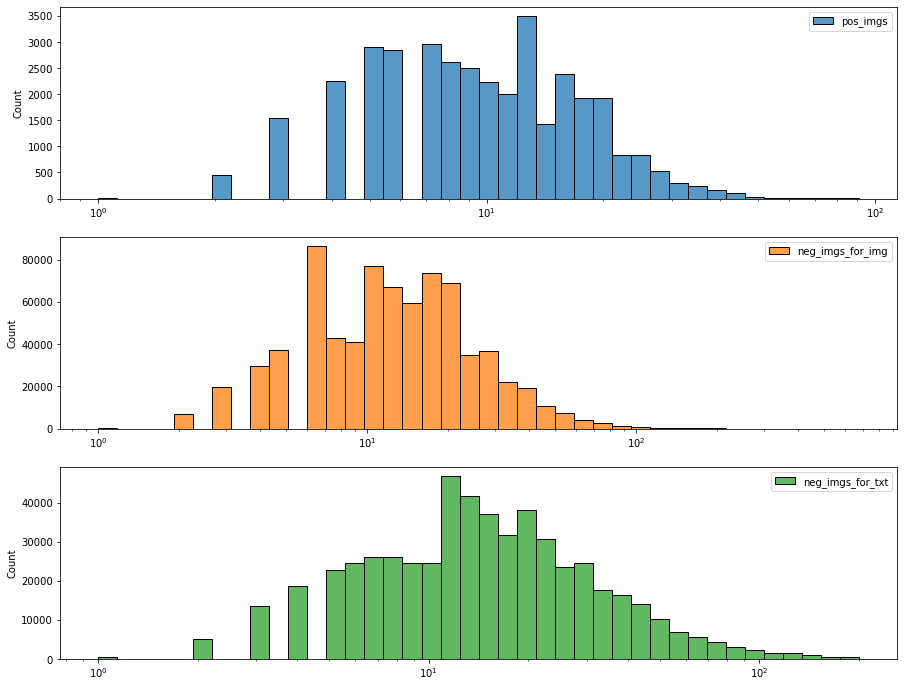

In [25]:
### Comparison of length distribution of img captions: 
# with pos imgs || with neg imgs for img data || with neg imgs for txt data
cap_lengths = {'pos_imgs': [], 'neg_imgs_for_img': [], 'neg_imgs_for_txt': []}
for k in img_dataset_0817_neg_ranked:
    for i in img_dataset_0817_neg_ranked[k]['img_posFacts']:
        cap_lengths['pos_imgs'].append(len(tokenizer.tokenize(i['caption'].strip())))
    for i in img_dataset_0817_neg_ranked[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_img'].append(len(tokenizer.tokenize(i['caption'].strip())))
for k in txt_dataset_0817_neg_ranked:
    for i in txt_dataset_0817_neg_ranked[k]['img_negFacts']:
        cap_lengths['neg_imgs_for_txt'].append(len(tokenizer.tokenize(i['caption'].strip())))
        
for k in cap_lengths:
    print(k, len(cap_lengths[k]))
for k in cap_lengths:
    print(k, np.mean(cap_lengths[k]), np.std(cap_lengths[k]))

colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(cap_lengths.keys()), colors[:3]):
    ax = axes[i]
    ax.set(xscale="log")
    sns.histplot(cap_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

pos_imgs 36579
neg_imgs_for_img 403612
neg_imgs_for_txt 309159
pos_imgs 11.329396648350146 7.1708882359480555
neg_imgs_for_img 11.347873700484623 7.102550716893851
neg_imgs_for_txt 15.28549063750368 14.198598954493905


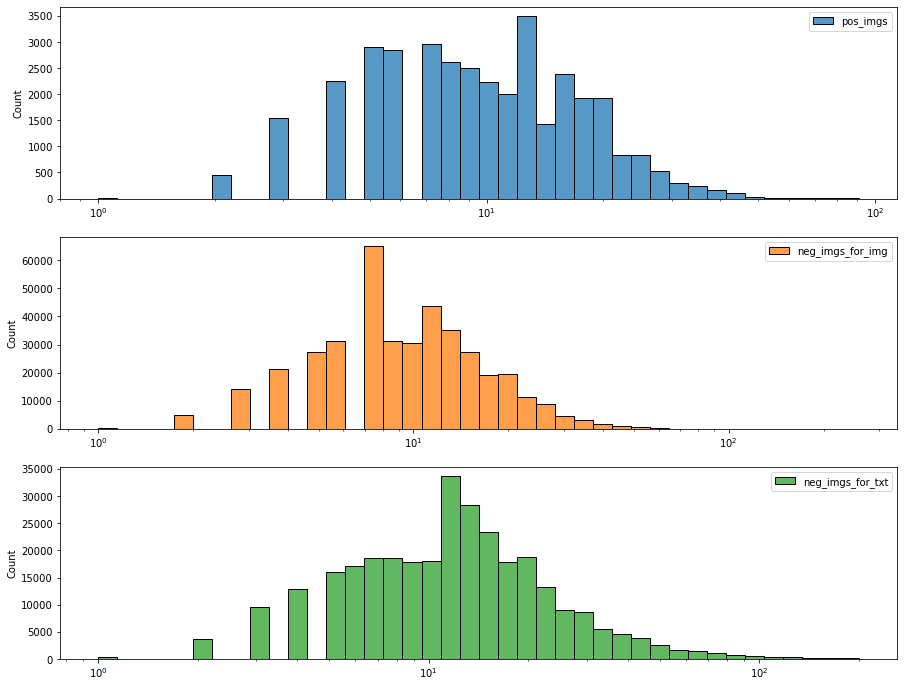

In [26]:
### Comparison of length distribution of img captions: 
# with pos imgs || with neg imgs for img data || with neg imgs for txt data
cap_lengths = {'pos_imgs': [], 'neg_imgs_for_img': [], 'neg_imgs_for_txt': []}
for k in img_dataset_0817_neg_ranked:
    for i in img_dataset_0817_neg_ranked[k]['img_posFacts']:
        cap_lengths['pos_imgs'].append(len(tokenizer.tokenize(i['caption'].strip())))
    for i in img_dataset_0817_neg_ranked[k]['img_negFacts'][:16]:
        cap_lengths['neg_imgs_for_img'].append(len(tokenizer.tokenize(i['caption'].strip())))
for k in txt_dataset_0817_neg_ranked:
    for i in txt_dataset_0817_neg_ranked[k]['img_negFacts'][:16]:
        cap_lengths['neg_imgs_for_txt'].append(len(tokenizer.tokenize(i['caption'].strip())))
        
for k in cap_lengths:
    print(k, len(cap_lengths[k]))
for k in cap_lengths:
    print(k, np.mean(cap_lengths[k]), np.std(cap_lengths[k]))

colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(cap_lengths.keys()), colors[:3]):
    ax = axes[i]
    ax.set(xscale="log")
    sns.histplot(cap_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

pos_snippets 51694
neg_snippets_for_img 910562
neg_snippets_for_txt 733049
pos_snippets 62.763957132355785 18.499291192222373
neg_snippets_for_img 43.28744445737907 12.956472199990827
neg_snippets_for_txt 47.910063310911006 15.44974242805947


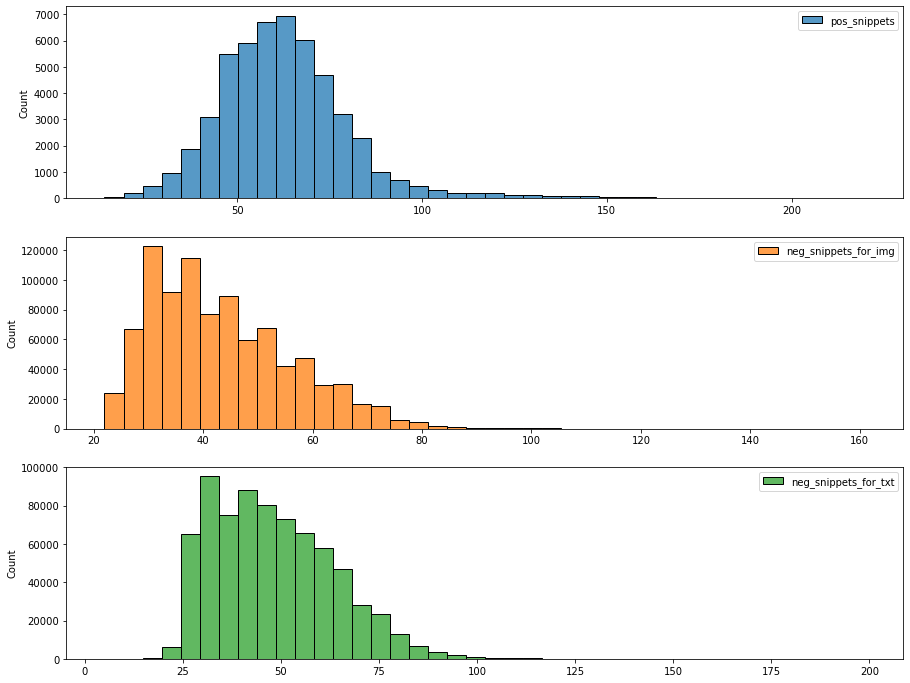

In [27]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'pos_snippets': [], 'neg_snippets_for_img': [], 'neg_snippets_for_txt': []}
for k in txt_dataset_0817_neg_ranked:
    for f in txt_dataset_0817_neg_ranked[k]['txt_posFacts']:
        snippet_lengths['pos_snippets'].append(len(tokenizer.tokenize(f['fact'])))
    for f in txt_dataset_0817_neg_ranked[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_txt'].append(len(tokenizer.tokenize(f['fact'])))
for k in img_dataset_0817_neg_ranked:
    for f in img_dataset_0817_neg_ranked[k]['txt_negFacts']:
        snippet_lengths['neg_snippets_for_img'].append(len(tokenizer.tokenize(f['fact'])))
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(snippet_lengths.keys()), colors[:3]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

pos_snippets 51694
neg_snippets_for_img 390117
neg_snippets_for_txt 370957
pos_snippets 62.763957132355785 18.499291192222373
neg_snippets_for_img 48.16085430781022 14.584113115875766
neg_snippets_for_txt 51.80009003738978 16.727910362080777


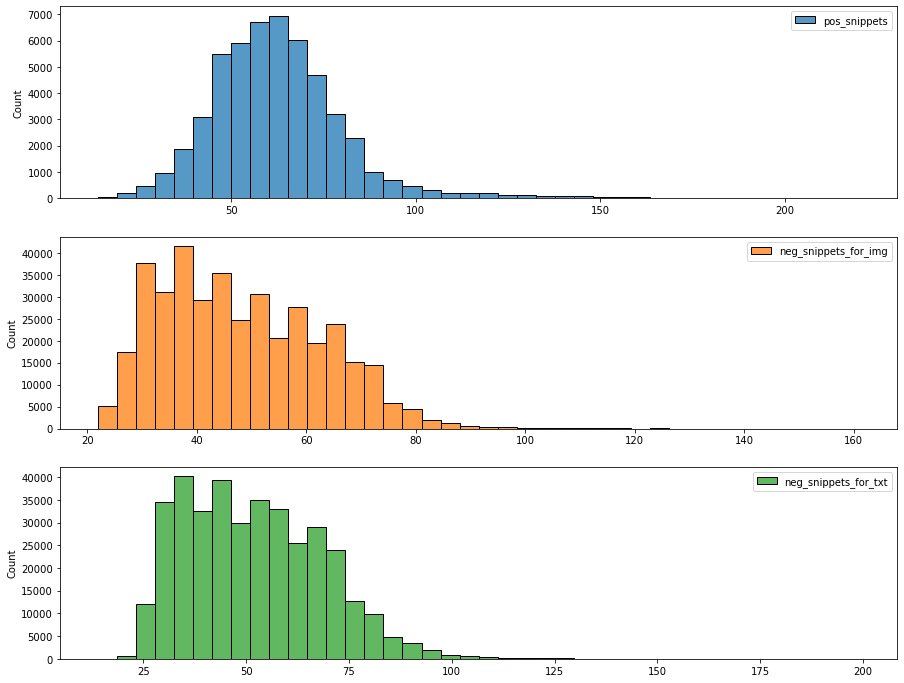

In [28]:
### Comparison of length distribution of snippets: 
# with pos snippets || with neg snippets for img data || with neg snippets for txt data
snippet_lengths = {'pos_snippets': [], 'neg_snippets_for_img': [], 'neg_snippets_for_txt': []}
for k in txt_dataset_0817_neg_ranked:
    for f in txt_dataset_0817_neg_ranked[k]['txt_posFacts']:
        snippet_lengths['pos_snippets'].append(len(tokenizer.tokenize(f['fact'])))
    for f in txt_dataset_0817_neg_ranked[k]['txt_negFacts'][:16]:
        snippet_lengths['neg_snippets_for_txt'].append(len(tokenizer.tokenize(f['fact'])))
for k in img_dataset_0817_neg_ranked:
    for f in img_dataset_0817_neg_ranked[k]['txt_negFacts'][:16]:
        snippet_lengths['neg_snippets_for_img'].append(len(tokenizer.tokenize(f['fact'])))
        
for k in snippet_lengths:
    print(k, len(snippet_lengths[k]))
for k in snippet_lengths:
    print(k, np.mean(snippet_lengths[k]), np.std(snippet_lengths[k]))
    
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(3, 1, sharex=False, figsize=(15,12))
for i, k, color in zip(range(3), list(snippet_lengths.keys()), colors[:3]):
    ax = axes[i]
    #ax.set(yscale="log")
    sns.histplot(snippet_lengths[k], ax=ax, kde=False, bins=40, label=k, color=color)
    ax.legend()

### Apply overlap strategy on ranked negative samples ([:16] & all)

F1 0.16472722969508105
RE 0.23521754565894837
PR 0.0930140822847225


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


lcs_q 0.2443690584197862
lcs_f 0.1386533075618319


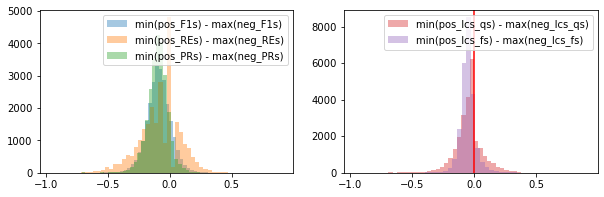

In [30]:
# posdominate
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [min(guid2posMetrics[guid][m]) - max(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="min(pos_{}s) - max(neg_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [min(guid2posMetrics[guid][m]) - max(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="min(pos_{}s) - max(neg_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

F1 0.8167330677290837


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RE 0.9379117194587985
PR 0.7350005916926354
lcs_q 0.9268667902646839
lcs_f 0.7430081653583686
F1 0.8905763086268786
RE 0.966707427714883
PR 0.8338527079799614
lcs_q 0.9536507435604118
lcs_f 0.8079365705494852


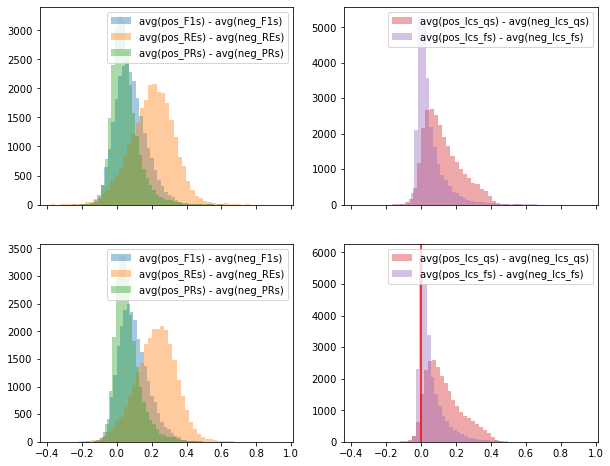

In [31]:
# avg(pos) - avg(neg)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,8))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0][0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m][:16]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[0][0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[0][1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m][:16]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[0][1].legend()

for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[1][0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[1][0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1][1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[1][1].legend()

plt.axvline(0.0, color='red')

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


F1 0.7064021143150172


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RE 0.9542818823715041
PR 0.3682300500966431
lcs_q 0.9466687704627036
lcs_f 0.22957674253481125


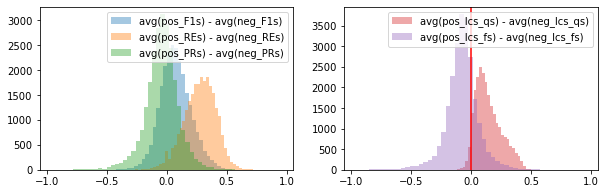

In [32]:
# avg(pos) - avg(neg_Img)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negImgMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(guid2negImgMetrics[guid][m]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

F1 0.4128436748057276


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RE 0.613151354976135
PR 0.2823162794367086
lcs_q 0.6022642104847935
lcs_f 0.3712279594493314


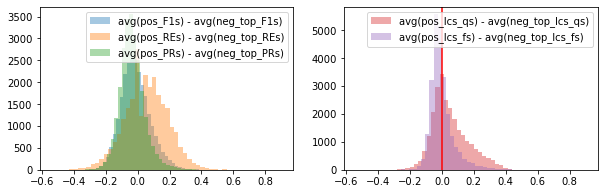

In [33]:
# avg(pos) - avg(neg_top)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[1].legend()
plt.axvline(0.0, color='red')

/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


F1 0.39639461954163546


/home/yingshac/miniconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RE 0.8345232929667469
PR 0.10429568853299673
lcs_q 0.75787937359473
lcs_f 0.06962250009861544
RE_aug_by_len_bonus 0.9084848723916217


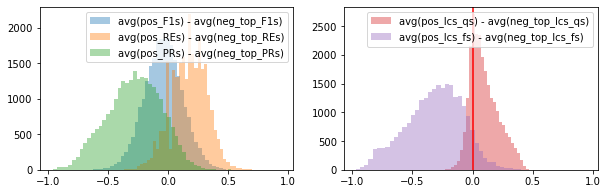

In [34]:
# avg(pos) - avg(negImg_top)
metrics = ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']
colors = sns.color_palette("tab10")
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,3))
for m, color in zip(metrics[:3], colors[:3]):
    ax = axes[0]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negImgMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[0].legend()
for m, color in zip(metrics[3:], colors[3:]):
    ax = axes[1]
    data = [np.mean(guid2posMetrics[guid][m]) - np.mean(sorted(guid2negImgMetrics[guid][m], reverse=True)[:len(guid2posMetrics[guid][m])]) for guid in guid2posMetrics]
    print(m, np.sum(np.array(data)>0) / len(data))
    sns.distplot(data, ax=ax, kde=False, label="avg(pos_{}s) - avg(neg_top_{}s)".format(m, m), color=color)
axes[1].legend()

data = [np.mean(guid2posMetrics[guid]['RE']) - np.mean(sorted(guid2negImgMetrics[guid]['RE_aug_by_len_bonus'], reverse=True)[:len(guid2posMetrics[guid]['RE'])]) for guid in guid2posMetrics]
print('RE_aug_by_len_bonus', np.sum(np.array(data)>0) / len(data))
plt.axvline(0.0, color='red')

In [35]:
def compute_retrieval_metrics(pred, gth):
    common = len(set(pred).intersection(gth))
    RE = common / len(gth)
    PR = common / len(pred)
    F1 = 2*PR*RE / (PR + RE + 1e-5)
    return F1, RE, PR

In [36]:
# Performance of top2<m> strategy (on pure txt distractors)
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for guid in guid2posMetrics:
        f_scores = guid2posMetrics[guid][m]
        all_scores = np.array(f_scores + guid2negMetrics[guid][m])
        pred = all_scores.argsort()[-2:][::-1]
        gth = range(len(guid2posMetrics[guid][m]))
        F1, RE, PR = compute_retrieval_metrics(pred, gth)
        F1s.append(F1)
        REs.append(RE)
        PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

F1
   F1 =  0.423282423860017
   RE =  0.4213489277214573
   PR =  0.42631454380497813
RE
   F1 =  0.6102865156292211
   RE =  0.6074461230983657
   PR =  0.6147094789160191
PR
   F1 =  0.3205573639170582
   RE =  0.3191570352254349
   PR =  0.3227683326101534
lcs_q
   F1 =  0.5489151995885332
   RE =  0.5463078379551103
   PR =  0.552976213956057
lcs_f
   F1 =  0.3602873717246253
   RE =  0.3587116879018579
   PR =  0.3627667547631257


In [37]:
# Performance of top2<m> strategy (pos snippets vs. negImg captions)
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for guid in guid2posMetrics:
        f_scores = guid2posMetrics[guid][m]
        all_scores = np.array(f_scores + guid2negImgMetrics[guid][m])
        pred = all_scores.argsort()[-2:][::-1]
        gth = range(len(guid2posMetrics[guid][m]))
        F1, RE, PR = compute_retrieval_metrics(pred, gth)
        F1s.append(F1)
        REs.append(RE)
        PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

F1
   F1 =  0.41068373988473894
   RE =  0.409117326075237
   PR =  0.4131592442112737
RE
   F1 =  0.787074743852884
   RE =  0.783136102454867
   PR =  0.7931837008402035
PR
   F1 =  0.15195597809076622
   RE =  0.15146674029952795
   PR =  0.1527750384600213
lcs_q
   F1 =  0.6992598898171138
   RE =  0.6959797772605946
   PR =  0.7043509131789673
lcs_f
   F1 =  0.114967559144902
   RE =  0.11467003274032582
   PR =  0.11547867934203779


In [38]:
# Performance of top2<m> strategy (pos snippets vs. [neg snippets + negImg captions])
for m in ['F1', 'RE', 'PR', 'lcs_q', 'lcs_f']:
    F1s = []
    REs = []
    PRs = []
    print(m)
    for guid in guid2posMetrics:
        f_scores = guid2posMetrics[guid][m]
        all_scores = np.array(f_scores + guid2negImgMetrics[guid][m] + guid2negMetrics[guid][m])
        pred = all_scores.argsort()[-2:][::-1]
        gth = range(len(guid2posMetrics[guid][m]))
        F1, RE, PR = compute_retrieval_metrics(pred, gth)
        F1s.append(F1)
        REs.append(RE)
        PRs.append(PR)
    print('   F1 = ', np.mean(F1s))
    print('   RE = ', np.mean(REs))
    print('   PR = ', np.mean(PRs))

F1
   F1 =  0.30614261199008425
   RE =  0.30503530432724546
   PR =  0.30789712437379196
RE
   F1 =  0.5980411558273997
   RE =  0.595290126622224
   PR =  0.6023233797483334
PR
   F1 =  0.10736363577191316
   RE =  0.10703062338106321
   PR =  0.10792473669677725
lcs_q
   F1 =  0.5286544231015684
   RE =  0.526325062785163
   PR =  0.5322866948049386
lcs_f
   F1 =  0.09067937508639111
   RE =  0.09048295267773789
   PR =  0.09102205041221254


In [39]:
# Sanity check
txt_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0817_neg_ranked.json", "r"))
img_dataset = json.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/img_dataset_0817_neg_ranked.json", "r"))
print(Counter([txt_dataset[k]['split'] for k in txt_dataset]))
print(len(set([txt_dataset[k]['Guid'] for k in txt_dataset])))

print(Counter([img_dataset[k]['split'] for k in img_dataset]))
print(Counter([img_dataset[k]['Qcate'] for k in img_dataset]))
print(len(set([img_dataset[k]['Guid'] for k in img_dataset])))

Counter({'train': 17812, 'test': 5084, 'val': 2455})
25351
Counter({'train': 16447, 'ood_test': 3987, 'val': 2511, 'ind_test': 2507})
Counter({'YesNo': 8429, 'Others': 6713, 'choose': 5240, 'number': 2339, 'color': 2069, 'shape': 662})
25452


In [42]:
pprint(img_dataset['25000'])

{'A': '"Walking and bicycles are allowed on La Rambla."',
 'Guid': 'dc7b4324d46f11ebba07a504a20e7724',
 'Keywords_A': '"walking,bicycles"',
 'Q': '"What forms of locomotion are allowed on La Rambla?"',
 'Qcate': 'Others',
 'Qtype': 'img-Singlehop',
 'img_negFacts': [{'caption': 'Las Ramblas Barcelona - panoramio',
                   'image_id': '10058243',
                   'imgUrl': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Las_Ramblas_Barcelona_-_panoramio.jpg/800px-Las_Ramblas_Barcelona_-_panoramio.jpg',
                   'overlap_scores': '(0.1818, 0.1667, 0.2, 0.1346, 0.2121, '
                                     '0.1667)',
                   'title': 'Las Ramblas Barcelona - panoramio',
                   'url': 'https://commons.wikimedia.org/wiki/File:Las_Ramblas_Barcelona_-_panoramio.jpg'},
                  {'caption': 'Hotel Catalonia Ramblas',
                   'image_id': '00010186',
                   'imgUrl': 'https://upload.wikimedia.org/wikipedia/c

In [44]:
### Add image_id to x_distractors
x_dis_src2idx = pickle.load(open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/x_dis_src2idx-Copy1.pkl", "rb"))
txt_dataset_0818 = copy.deepcopy(txt_dataset)
for k in txt_dataset_0818:
    for f in txt_dataset_0818[k]['img_negFacts']:
        try: f['image_id'] = x_dis_src2idx[f['imgUrl']]
        except: print("f***! k = {}, imgUrl = {}".format(k, f['imgUrl']))
json.dump(txt_dataset_0818, open("/home/yingshac/CYS/WebQnA/WebQnA_data_new/txt_dataset_0818.json", "w"), indent=4)

In [47]:
#spot check
pprint(txt_dataset_0818['22427'])

{'A': 'A-bomb',
 'Guid': 'bacd0e04-c5b0-4026-ac92-d9945e6d909f',
 'Major_Topic': 'military guns and firearms',
 'Q': 'What is an acceptable short-hand definition, with a single letter '
      'abbreviation, of the type of weapon of interest for the CNWDI?',
 'QType': 'text',
 'Topics': ['weapon', 'nuclear_weapons', 'weapons'],
 'TopicsCandidates': [],
 'img_negFacts': [{'caption': ' UN member states debate the idea of a '
                              'nuclear-weapon-ban treaty, Geneva, May 2016',
                   'image_id': 20078677,
                   'imgUrl': 'https://upload.wikimedia.org/wikipedia/commons/thumb/0/04/UN_working_group_on_nuclear_disarmament%2C_May_2016.jpg/800px-UN_working_group_on_nuclear_disarmament%2C_May_2016.jpg',
                   'overlap_scores': '(0.2353, 0.2222, 0.25, 0.0469, 0.0732, '
                                     '0.1322)',
                   'scores': '(0.03, 0.0, 0.01, 0.03, 0.019999999999999997)',
                   'title': 'Treaty on the 